# Data

In [2]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from simulatedata import simulatedata

# 设置kbar参数
kbar = 4

# 模拟数据，60%用于样本内估计，40%用于样本外预测。参见第4节关于模拟数据的原理说明
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    # 每日波动率
T = 7087                # 总样本量
E = np.rint(0.6*T).astype(int)  # 样本内数据量          
dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)  # 生成模拟数据
dat1E = dat1[0:E,]  # 样本内数据
dat1F = dat1[E:,]   # 样本外数据

# DEXJPUS数据，60%用于样本内估计，40%用于样本外预测
dat2 = pd.read_csv("DEXJPUS.csv")                                   
dat2 = dat2.loc[dat2.DEXJPUS != "."].DEXJPUS.astype(float)  # 移除非数值数据并转换为浮点型
dat2 = np.array(dat2)
dat2_rtn = dat2[0:-1]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1])  # 计算对数收益率
dat2 = dat2[dat2 != 0]  # 移除零收益率
dat2 = dat2[:,np.newaxis]  # 转换为二维数组
dat2E = dat2[0:E,]  # 样本内数据
dat2F = dat2[E:,]   # 样本外数据

# 输出各数据集的形状
dat1E.shape, dat1F.shape, dat2E.shape, dat2F.shape

CPU times: user 2.64 s, sys: 399 ms, total: 3.04 s
Wall time: 10.6 s


((4252, 1), (2835, 1), (4252, 1), (2835, 1))

# Stats

In [8]:
from scipy import stats

j = stats.describe(dat1.flatten())
print("描述性统计 - 模拟数据：","\n"
      f"观测数 = {j.nobs}\n"
      f"最小值, 最大值 = {j.minmax[0]:.5f}, {j.minmax[1]:.5f}\n"
      f"均值 = {j.mean:.5f}\n"
      f"方差 = {j.variance:.5f}\n"
      f"标准差 = {np.sqrt(j.variance):.5f}\n"
      f"偏度 = {j.skewness:.5f}\n"
      f"峰度 = {j.kurtosis:.5f}")

k = stats.describe(dat2.flatten())
print("描述性统计 - DEXJPUS：","\n"
      f"观测数 = {k.nobs}\n"
      f"最小值, 最大值 = {k.minmax[0]:.5f}, {k.minmax[1]:.5f}\n"
      f"均值 = {k.mean:.5f}\n"
      f"方差 = {k.variance:.5f}\n"
      f"标准差 = {np.sqrt(k.variance):.5f}\n"
      f"偏度 = {k.skewness:.5f}\n"
      f"峰度 = {k.kurtosis:.5f}")

描述性统计 - 模拟数据： 
观测数 = 7087
最小值, 最大值 = -1.25779, 1.00386
均值 = -0.00079
方差 = 0.01477
标准差 = 0.12155
偏度 = -0.11522
峰度 = 9.87916
描述性统计 - DEXJPUS： 
观测数 = 7087
最小值, 最大值 = -0.05630, 0.06256
均值 = -0.00011
方差 = 0.00004
标准差 = 0.00666
偏度 = -0.38715
峰度 = 5.46706


# Time series analysis

In [12]:
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="muted")

def tsdisplay(y, figsize = (16,9), title = "", color = ""):
    tmp_data = pd.Series(y)
    
    fig = plt.figure(figsize = figsize)
    # 绘制时间序列
    tmp_data.plot(ax = fig.add_subplot(311), title = f"$Log returns time series: {title}$", legend = False, color=color, linewidth=0.5, alpha=0.75)
    # 绘制ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(323))
    # 绘制PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(324))
    # 数据的QQ图:
    sm.qqplot(tmp_data, line='s', color=color, ax = fig.add_subplot(325)) 
    plt.title("Q-Q图")
    # 绘制残差直方图:
    fig.add_subplot(326).hist(tmp_data, color=color, bins = 120)
    plt.title("直方图")
    # 调整图表布局:
    plt.tight_layout()

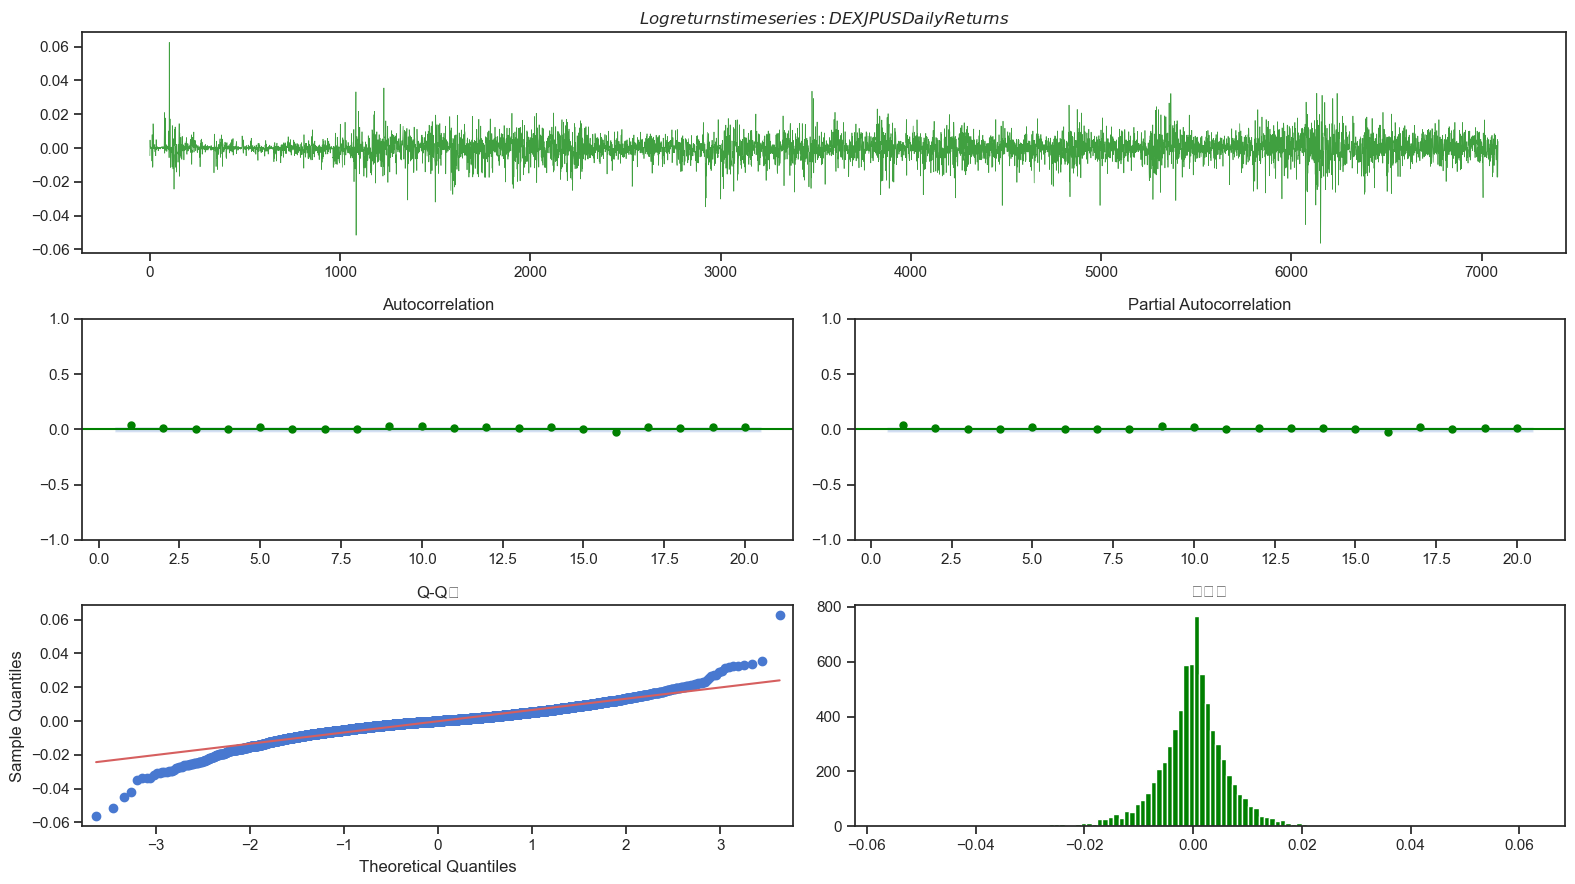

In [14]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "DEXJPUS Daily Returns", color='green')

/opt/anaconda3/envs/MSM_timeserise/lib/python3.12/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2823529411764706, 0.47058823529411764, 0.8156862745098039, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


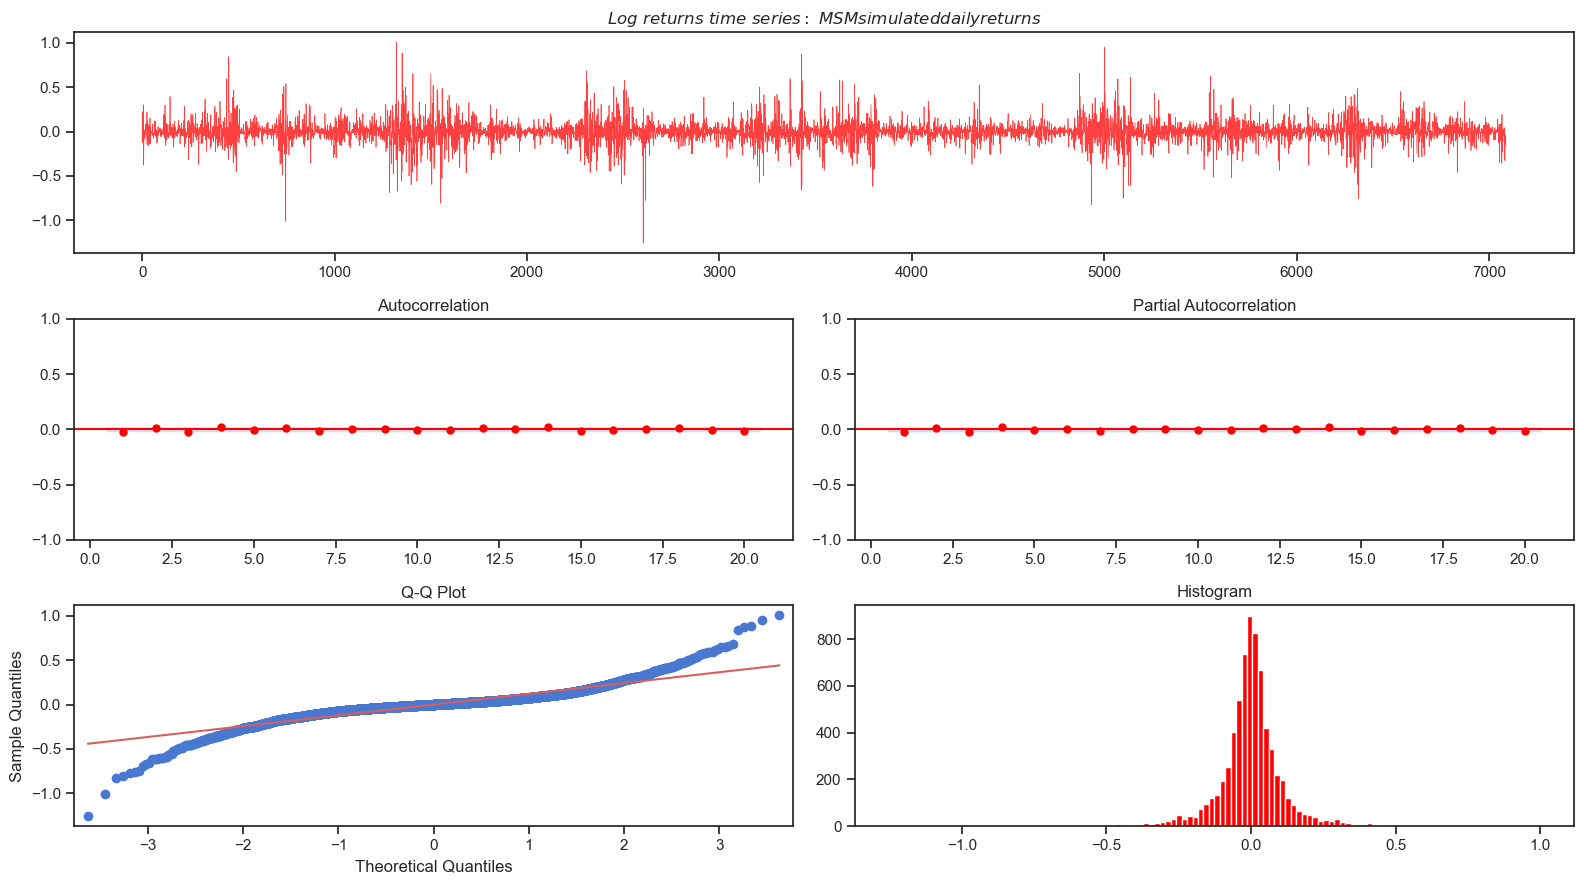

In [6]:
s = np.array(dat1).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MSM simulated daily returns", color='red')

# Model estimation

**Simulated dataset**

# 我对模拟数据集应用最大似然估计，以检查我的模型计算的参数是否与真实值足够接近。函数 `simulateData_NumPy(b,m0,g_kbar,sig,kbar,T)` 模拟了一个数据集，其真实参数为 $b = 6$, $m_0 = 1.6$, $gamma_{\bar k} = 0.8$, 和 ${\bar \sigma} = 2$；我进一步指定了 5 个乘数（因此 $\bar k = 5$）。我为模拟设置了 $T$ 个观测值，设定 $T = 7087$，以确保模拟数据集的长度（观测值数量）与后续部分的 DEXJPUS 数据集相同，在该部分中我复制了 Calvet & Fisher (2004) 的结果。我观察到，模拟数据返回的参数在多次测试运行中始终接近真实参数，因此得出结论，MSM 模型正常工作。

In [7]:
%%time
import numpy as np
from msm import glo_min, loc_min, g_LLb_h, g_LL, _LL, g_pi_t, _t, g_t, s_p, unpack 

data = dat1E               # Simulated dta
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)

# name parameters for later use:
b_sim = parameters[0]
m_0_sim = parameters[1]
gamma_kbar_sim = parameters[2]
sigma_sim = parameters[3]
LL_sim = LL

print("Parameters from glo_min for Simulated dataset: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_sim,"\n"
      'm_0 = %.5f' % m_0_sim,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_sim,"\n"
      'sigma = %.5f' % (sigma_sim*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_sim,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

Parameters from glo_min for Simulated dataset:  
kbar =  4 
b = 5.56767 
m_0 = 1.60915 
gamma_kbar = 0.73815 
sigma = 2.10991 
Likelihood = -4129.45691 
niter =  1 
output =  ['requested number of basinhopping iterations completed successfully'] 

CPU times: user 2.04 s, sys: 121 ms, total: 2.16 s
Wall time: 5.21 s


**DEXJPUS**

# 我对 DEXJPUS 数据集应用最大似然估计，以复制 Calvet & Fisher (2004, 2008) 的结果，从而为后续与其他数据的分析提供锚点。
# $\\[0.1in]$

In [7]:
%%time
import numpy as np
from msm import glo_min, loc_min, g_LLb_h, g_LL, _LL, g_pi_t, _t, g_t, s_p, unpack 

data = dat2E               # DEXJPUS
niter = 1
temperature = 1.0
stepsize = 1.0

parameters, LL, niter, output = glo_min(kbar, data, niter, temperature, stepsize)

# name parameters for later use:
b_dex = parameters[0]
m_0_dex = parameters[1]
gamma_kbar_dex = parameters[2]
sigma_dex = parameters[3]
LL_dex = LL

print("Parameters from glo_min for DEXJPUS: ", "\n"
      "kbar = ", kbar,"\n"
      'b = %.5f' % b_dex,"\n"
      'm_0 = %.5f' % m_0_dex,"\n"
      'gamma_kbar = %.5f' % gamma_kbar_dex,"\n"
      'sigma = %.5f' % (sigma_dex*np.sqrt(252)),"\n"
      'Likelihood = %.5f' % LL_dex,"\n"
      "niter = " , niter,"\n"
      "output = " , output,"\n")

Parameters from glo_min for DEXJPUS:  
kbar =  4 
b = 9.26033 
m_0 = 1.62308 
gamma_kbar = 0.71612 
sigma = 0.07682 
Likelihood = -16441.86030 
niter =  1 
output =  ['requested number of basinhopping iterations completed successfully'] 

Wall time: 1.38 s


***